The __Official__ Colab Demo for ICCV'21 paper

__[Dressing in Order: Recurrent Person Image Generation for Pose Transfer, Virtual Try-on and Outfit Editing](https://arxiv.org/abs/2104.07021)__


\[[Code](https://github.com/cuiaiyu/dressing-in-order)\]
\[[Paper](https://arxiv.org/abs/2104.07021)\]

# Read Before Starting
- This Colab Demo is available for __non-commercial research purposes__ only.
- This Colab contains data downloading scripts. __*Please make sure you are legally allowed to use the [DeepFahsion-MultiModal dataset](https://github.com/yumingj/DeepFashion-MultiModal) as required by [their license]() before trying this demo.*__


# Step 0: Install Environment
(This demo only supports inference, so we don't install GFLA.)

In [1]:
# check GPU
# If you don't have GPU, please set it by Runtime -> Change runtime type
!nvidia-smi

Tue Dec  3 06:43:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
# install DiOr
import os
!git clone https://github.com/cuiaiyu/dressing-in-order
repo_name='dressing-in-order'
os.chdir(f'./{repo_name}')

fatal: destination path 'dressing-in-order' already exists and is not an empty directory.


In [1]:
# !pip install scikit-image==0.16.2
# !pip install tensorboardX

# Step 1: Download Data
This Data is from [DeepFashion-Multimodal](https://arxiv.org/abs/2205.15996) [1].

Please make sure you read [the dataset license](https://github.com/yumingj/DeepFashion-MultiModal/blob/main/LICENSE) before running the below code.

You are __responsible__ to make sure whether the data is available for your usage.

```[1] Jiang, Yuming, et al. "Text2human: Text-driven controllable human image generation." ACM Transactions on Graphics (TOG) 41.4 (2022): 1-11.```



In [1]:
!cd dressing-in-order

In [5]:
!ls 

Copy of dress_in_order_demo(1).ipynb ffff.txt
LICENSE                              generate_all.py
Pose123.png                          models
README.md                            options
checkpoints                          output_image.png
cover_images                         requirements.txt
data                                 scripts
datasets                             tools
demo.ipynb                           train.py
dressing-in-order                    utils


In [2]:
# download data from https://github.com/yumingj/DeepFashion-MultiModal
import os
from tqdm.notebook import tqdm

if not os.path.exists("data/"):
  os.system("mkdir data")

def download_from_gdrive(dst_root, fn, gdrive_path, iszip=True):
  if not os.path.exists(dst_root):
    os.system("mkdir {}".format(dst_root))
  if not os.path.exists("{}/{}".format(dst_root, fn)):
    os.system("gdown {}".format(gdrive_path))
    if iszip:
      os.system("unzip {}.zip".format(fn))
      os.system("rm {}.zip".format(fn))
    os.system("mv {} {}/".format(fn, dst_root))
  print("download {}.".format(fn))

# download data
download_from_gdrive("data", "testM_lip", "1toeQwAe57LNPTy9EWGG0u1XfTI7qv6b1")
download_from_gdrive("data", "images", "1U2PljA7NE57jcSSzPs21ZurdIPXdYZtN")
download_from_gdrive("data","fasion-pairs-test.csv","12fZKGf0kIu5OX3mjC-C3tptxrD8sxm7x",iszip=False)
download_from_gdrive("data","fasion-annotation-test.csv","1MxkVFFtNsWFshQp_TA7qwIGEUEUIpYdS",iszip=False)
download_from_gdrive("data","standard_test_anns.txt","19nJSHrQuoJZ-6cSl3WEYlhQv6ZsAYG-X",iszip=False)




download testM_lip.
download images.
download fasion-pairs-test.csv.
download fasion-annotation-test.csv.
download standard_test_anns.txt.


In [3]:
# filter images (exclude training data and rename the files)
if not os.path.exists("data/test"):
  os.mkdir("data/test")
target_fns = [fn[:-4] for fn in os.listdir("data/testM_lip")]
print("Len of images " , len(os.listdir("data/images/")))
for fn in tqdm(os.listdir("data/images")):
 # print(fn)
  elements = fn.split("-")
  if len(elements) >= 3:  
      elements[2] = elements[2].replace("_","")
      last_elements = elements[-1].split("_")
      elements[-1] = last_elements[0] + "_" + last_elements[1] + last_elements[2]
      new_fn = "fashion"+"".join(elements)

  if new_fn[:-4] in target_fns:
    os.system("mv {} {}".format("data/images/"+fn, "data/test/"+new_fn))


Len of images  40659


  0%|          | 0/40659 [00:00<?, ?it/s]

In [4]:
#!pip install scikit-image --upgrade
#!pip install scikit-image==0.18.3

# Step 2: Load Pre-trained Model

In [5]:
import torch
from models.dior_model import DIORModel
import os, json
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

/opt/anaconda3/envs/dressinorder/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/dressinorder/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/anaconda3/envs/dressinorder/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/dressinorder/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/dressinorder/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/dressinorder/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/dressinorder/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with

In [6]:
dataroot = 'data'
exp_name = 'DIORv1_64' # DIOR_64
epoch = 'latest'
netG = 'diorv1' # dior
ngf = 64

## this is a dummy "argparse"
class Opt:
    def __init__(self):
        pass
if True:
    opt = Opt()
    opt.dataroot = dataroot
    opt.isTrain = False
    opt.phase = 'test'
    opt.n_human_parts = 8; opt.n_kpts = 18; opt.style_nc = 64
    opt.n_style_blocks = 4; opt.netG = netG; opt.netE = 'adgan'
    opt.ngf = ngf
    opt.norm_type = 'instance'; opt.relu_type = 'leakyrelu'
    opt.init_type = 'orthogonal'; opt.init_gain = 0.02; opt.gpu_ids = [0]
    opt.frozen_flownet = True; opt.random_rate = 1; opt.perturb = False; opt.warmup=False
    opt.name = exp_name
    opt.vgg_path = ''; opt.flownet_path = ''
    opt.checkpoints_dir = 'checkpoints'
    opt.frozen_enc = True
    opt.load_iter = 0
    opt.epoch = epoch
    opt.verbose = False

# create model
#os.mkdir("checkpoints")
download_from_gdrive("checkpoints", "DIORv1_64", "1MyHq-P0c8zz7ey7p_HTTZKeMie5ZuNlb")

model = DIORModel(opt)
model.setup(opt)


download DIORv1_64.


/opt/anaconda3/envs/dressinorder/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/dressinorder/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


load vgg ckpt from torchvision dict.
[init] init pre-trained model vgg.
Initializing network on device: mps
initialize network with orthogonal


/opt/anaconda3/envs/dressinorder/lib/python3.10/site-packages/torch/nn/init.py:610: UserWarning: The operator 'aten::linalg_qr.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1733146601134/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  q, r = torch.linalg.qr(flattened)


Initializing network on device: mps
initialize network with orthogonal
Initializing network on device: mps
initialize network with kaiming
Initializing network on device: mps
initialize network with orthogonal
Initializing network on device: mps
[init] frozen net netVGG.
[init] frozen net netFlow.
[init] frozen net netE_attr.
[init] frozen net netE_attr.
loading the model from checkpoints/DIORv1_64/latest_net_E_attr.pth
loading the model from checkpoints/DIORv1_64/latest_net_G.pth
not exsits checkpoints/DIORv1_64/latest_net_VGG.pth
loading the model from checkpoints/DIORv1_64/latest_net_Flow.pth
---------- Networks initialized -------------
[Network E_attr] Total number of parameters : 1.191 M
[Network G] Total number of parameters : 16.501 M
[Network VGG] Total number of parameters : 0.113 M
[Network Flow] Total number of parameters : 6.608 M
-----------------------------------------------
[tensorboard] init tensorboard @ checkpoints/DIORv1_64/test


/Users/alokkumar/MyDrive/PythonResearch /Github-Downloads /DeepFashionMultimodal/DressInOrderSecondTry/dressing-in-order/models/base_model.py:316: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this expe

-1

In [7]:
# load data
from datasets.deepfashion_datasets import DFVisualDataset
Dataset = DFVisualDataset
ds = Dataset(dataroot=dataroot, dim=(256,176), n_human_part=8)

# preload a set of pre-selected models defined in "standard_test_anns.txt" for quick visualizations
inputs = dict()
for attr in ds.attr_keys:
    inputs[attr] = ds.get_attr_visual_input(attr)

# define some tool functions for I/O
def load_img(pid, ds):
    if len(pid[0]) < 10: # load pre-selected models
        person = inputs[pid[0]]
        person = (i.to("mps") for i in person)
        pimg, parse, to_pose = person
        pimg, parse, to_pose = pimg[pid[1]], parse[pid[1]], to_pose[pid[1]]
    else: # load model from scratch
        person = ds.get_inputs_by_key(pid[0])
        person = (i.to("mps") for i in person)
        pimg, parse, to_pose = person
    return pimg.squeeze(), parse.squeeze(), to_pose.squeeze()


# define dressing-in-order function (the pipeline)
def dress_in_order(model, pid, pose_id=None, gids=[], ogids=[], order=[5,1,3,2], perturb=False):
    PID = [0,4,6,7]
    GID = [2,5,1,3]
    # encode person
    pimg, parse, from_pose = load_img(pid, ds)
    if perturb:
        pimg = perturb_images(pimg[None])[0]
    if not pose_id:
        to_pose = from_pose
    else:
        to_img, _, to_pose = load_img(pose_id, ds)
    psegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None], PID)

    # encode base garments
    gsegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None])


    # swap base garment if any
    gimgs = []
    for gid in gids:
        _,_,k = gid
        gimg, gparse, pose =  load_img(gid, ds)
        seg = model.encode_single_attr(gimg[None], gparse[None], pose[None], to_pose[None], i=gid[2])
        gsegs[gid[2]] = seg
        gimgs += [gimg * (gparse == gid[2])]

    # encode garment (overlay)
    garments = []
    over_gsegs = []
    oimgs = []
    for gid in ogids:
        oimg, oparse, pose = load_img(gid, ds)
        oimgs += [oimg * (oparse == gid[2])]
        seg = model.encode_single_attr(oimg[None], oparse[None], pose[None], to_pose[None], i=gid[2])
        over_gsegs += [seg]

    gsegs = [gsegs[i] for i in order] + over_gsegs
    gen_img = model.netG(to_pose[None], psegs, gsegs)

    return pimg, gimgs, oimgs, gen_img[0], to_pose



In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib tk
%matplotlib inline

def plot_img(pimg=[], gimgs=[], oimgs=[], gen_img=[], pose=None, plotName = "output_img"):
    # Process pose if provided
    if pose is not None:
        import utils.pose_utils as pose_utils
        print("Pose shape:", pose.size())
        kpt = pose_utils.draw_pose_from_map(pose.cpu().numpy().transpose(1, 2, 0), radius=6)[0]
        kpt = np.clip(kpt / 255.0, 0, 1)  # Normalize to [0, 1]

    # Convert inputs to lists if they are not already
    if not isinstance(pimg, list):
        pimg = [pimg]
    if not isinstance(gen_img, list):
        gen_img = [gen_img]
    
    # Combine all images for display
    out_images = pimg + gimgs + oimgs + gen_img
    if out_images:
        # Concatenate along width
        out = torch.cat(out_images, dim=2).float().cpu().detach().numpy()
        out = (out + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
        out = np.transpose(out, [1, 2, 0])  # Convert to HWC format

        # Clip to valid range for visualization
        out = np.clip(out, 0, 1)

        # Append pose visualization if available
        if pose is not None:
            out = np.concatenate((kpt, out), axis=1)
    else:
        # If no image is provided, just display the pose
        out = kpt

    # Plotting
    fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
    plt.axis('off')
    plt.imshow(out)
    plt.savefig(plotName+'.png')  # Save as a PNG file
    #plt.close(fig)  # Close the figure after saving
    plt.show()


# Applications

NOTE: INDEX OF GARMENT is used as following:

- 'top':5, # dress is also considered as top.
- 'bottom':1,
- 'hair':2,
- 'jacket':3


## Pose Transfer

Pose shape: torch.Size([18, 256, 176])


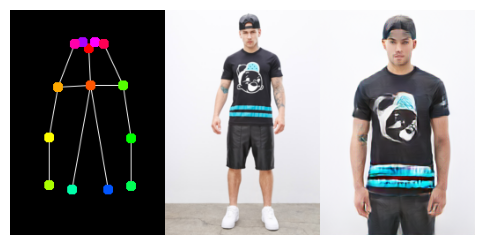

In [34]:
import numpy as np
# person id
pid = ("print", 3, None) # load the 0-th person from "print" group, NONE (no) garment is interested
# pose id (take this person's pose)
pose_id = ("print", 2, None) # load the 2-nd person from "print" group, NONE (no) garment is interested
# generate
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid, pose_id=pose_id)
plot_img(pimg, gimgs, oimgs, gen_img, pose, "first")

## Virtual Try-On (Tucking in/out)

Users can control the tuck-in and tuck-out results when there is overlap between the top garment and the bottom garment.

Pose shape: torch.Size([18, 256, 176])


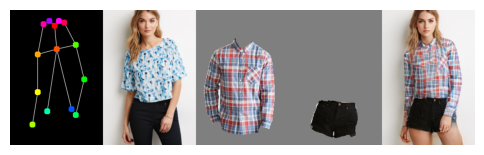

Pose shape: torch.Size([18, 256, 176])


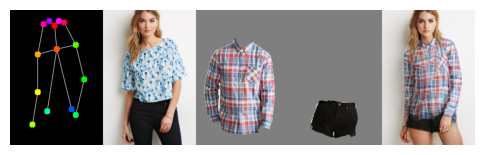

In [40]:
pid = ("pattern",1, None) # load the 3-rd person from "pattern" group, NONE (no) garment is interested
gids = [
   ("plaid",0,5), # load the 0-th person from "plaid" group, garment #5 (top) is interested
   ("pattern",3,1),  # load the 3-rd person from "pattern" group, garment #1 (bottom) is interested
       ]

# tuck in (dressing order: hair, top, bottom)
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid, gids=gids, order=[2,5,1])
plot_img(pimg, gimgs, gen_img=gen_img, pose=pose)

# not tuckin (dressing order: hair, bottom, top)
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid, gids=gids, order=[2,1,5])
plot_img(pimg, gimgs, gen_img=gen_img, pose=pose)



## Virtual Try-On (Layering)


Pose shape: torch.Size([18, 256, 176])


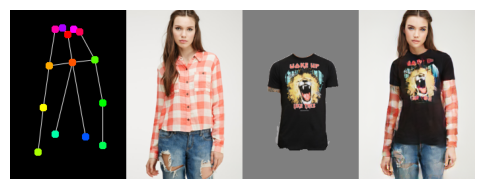

In [14]:
pid = ('plaid',3, 5)
ogids = [('print', 2, 5)]
# tuck in
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid, ogids=ogids)
plot_img(pimg, gimgs, oimgs, gen_img, pose)

## Virual Try-On (Layering - Muliple)


Pose shape: torch.Size([18, 256, 176])


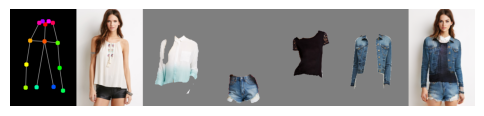

In [15]:
# person id
pid = ("fashionWOMENBlouses_Shirtsid0000637003_1front.jpg", None , None) # load person from the file

# garments to try on (ordered)
gids = [
    ("gfla",2,5),
    ("strip",3,1),
       ]

# garments to lay over (ordered)
ogids = [
 ("fashionWOMENTees_Tanksid0000159006_1front.jpg", None ,5),
 ('fashionWOMENJackets_Coatsid0000645302_1front.jpg', None ,3),
]

# dressing in order
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid=pid, gids=gids, ogids=ogids)
plot_img(pimg, gimgs, oimgs, gen_img, pose)

## Opacity

(-0.5, 1231.5, 255.5, -0.5)

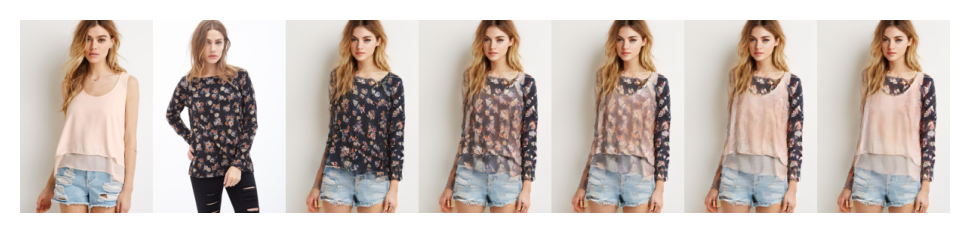

In [16]:

def dress_in_order_opcaity(model, pid, pose_id=None, gids=[], ogids=[], order=[5,1,3,2]):
    PID = [0,4,6,7]
    # encode person
    pimg, parse, from_pose = load_img(pid, ds)
    if not pose_id:
        to_pose = from_pose
    else:
        to_img, _, to_pose = load_img(pose_id, ds)
    psegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None], PID)

    # encode base garments
    gsegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None])

    # swap base garment if any
    gimgs = []
    for gid in gids:
        gimg, gparse, pose =  load_img(gid, ds)
        seg = model.encode_single_attr(gimg[None], gparse[None], pose[None], to_pose[None], i=gid[2])
        gsegs[gid[2]] = seg
        gimgs += [gimg]

    # encode garment (overlay)
    garments = []
    over_gsegs = []
    oimgs = []
    for gid in ogids:
        oimg, oparse, pose = load_img(gid, ds)
        oimgs.append(oimg)
        seg = model.encode_single_attr(oimg[None], oparse[None], pose[None], to_pose[None], i=gid[2])
        over_gsegs += [seg]

    gsegs = [gsegs[i] for i in order] + over_gsegs
    gen_img = model.netG(to_pose[None], psegs, gsegs)

    gmap, mask = gsegs[-1]
    gens = []
    for alpha in [0, 0.99, 0.6, 0.35, 0.25]:
        curr_mask = mask.clone() # * alpha
        curr_mask[curr_mask >= alpha] = alpha
        gsegs[-1] = gmap, curr_mask
        img = model.netG(to_pose[None], psegs, gsegs, alpha=0.1999)
        gens.append(img[0])
    return pimg, gimgs, oimgs, gens, to_pose

pid = ('fashionWOMENBlouses_Shirtsid0000270306_1front.jpg', None, 5)
gids = [('fashionWOMENTees_Tanksid0000255303_1front.jpg', None, 5)]
ogids = [('fashionWOMENBlouses_Shirtsid0000270306_1front.jpg', None, 5)]

pimg, gimgs, oimgs, gens, to_pose = dress_in_order_opcaity(model, pid=pid, gids=gids, ogids=ogids)

# plot results: (source person, source garment-inside, transparency results)
output = torch.cat([pimg, gimgs[0],gens[0]] + gens[::-1][:-1], 2)
output = (output + 1) / 2
output = output.float().cpu().detach().numpy()
output = np.transpose(output, [1,2,0])
fig=plt.figure(figsize=(6,4), dpi= 200, facecolor='w', edgecolor='k')
plt.imshow(output)
plt.axis('off')

## Reshaping


In [17]:

def dress_in_order_texshape(model, pid, target=5, shape_id=None, tex_patch=None, order=[2,5,1,3]):
    PID = [0,4,6,7]
    # encode person
    pimg, parse, from_pose = load_img(pid, ds)
    to_pose = from_pose
    psegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None], PID)

    # encode base garments
    gsegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None])

    fmap, mask = gsegs[target]
    gimg = pimg*(parse==target)
    if shape_id != None:
        gimg, gparse, pose =  load_img(shape_id, ds)
        _, mask = model.encode_single_attr(gimg[None], gparse[None], pose[None], to_pose[None], i=target)
        shape_img = [gimg*(gparse==target)]
    else:
        shape_img = []
    if tex_patch != None:
        fmap = model.netE_attr(tex_patch, model.netVGG)
    gsegs[target] = fmap, mask
    gsegs = [gsegs[i] for i in order]
    gen_img = model.netG(to_pose[None], psegs, gsegs)

    return pimg, [gimg], shape_img, gen_img[0], to_pose

Pose shape: torch.Size([18, 256, 176])


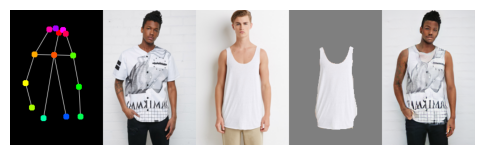

In [18]:
pid = ('print', 0, 5)
shape_id = ('plain', 2, 5)

pimg, gimgs, oimgs, gen_img, pose = dress_in_order_texshape(model, pid, shape_id=shape_id)
plot_img(pimg, gimgs, oimgs, gen_img, pose)

## Texture Transfer

Pose shape: torch.Size([18, 256, 176])


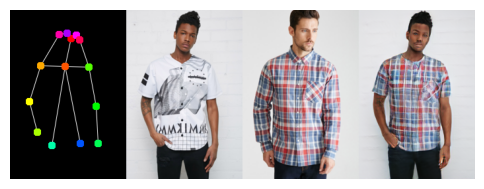

In [19]:

pid = ('print', 0, 5)
patch_id = ('plaid', 0, 5)
patch, parse, from_pose = load_img(patch_id, ds)
pimg, gimgs, oimgs, gen_img, pose = dress_in_order_texshape(model, pid, tex_patch=patch[None])
plot_img(pimg, [patch], oimgs, gen_img, pose)


## Print Insertion (RGBA image required)


In [16]:
#pip install gdown


In [23]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Assuming the function load_img and model are already defined elsewhere

fn = "data/doge.jpg"
pid = ('plain', 3, None)

image = cv2.imread(fn, cv2.IMREAD_UNCHANGED)  # Read RGBA image
if image.shape[2] == 3:  # If the image has only RGB channels
    # Convert to RGBA by adding an alpha channel (fully opaque)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGRA)
    
# Put the print on a blank canvas
x, y, h, w = 90, 60, 80, 70
image = cv2.resize(image, (w, h))
bg = np.zeros((256, 176, 4), dtype=np.uint8)  # Create an RGBA background
bg[x:x + h, y:y + w] = image  # Paste the image on the background
image = bg

# Crop the print image and apply transparency mask
trans_mask = image[:, :, 3] != 0  # Extract the alpha mask (non-zero alpha)
image = image[:, :, 2::-1].transpose(2, 0, 1)  # Convert from BGRA to BGR (channels)
image = (image / 255.0) * 2 - 1  # Normalize to [-1, 1]
image = image * trans_mask[None]  # Apply the transparency mask

# Run DiOr model (Assuming `load_img` and `model` are defined)
pimg, parse, to_pose = load_img(pid, ds)
psegs = model.encode_attr(pimg[None], parse[None], to_pose[None], to_pose[None], [0, 4, 6, 7])
gsegs = model.encode_attr(pimg[None], parse[None], to_pose[None], to_pose[None], [5, 1, 2])

# Insert the print into the image
print_image = torch.from_numpy(image).float().to('mps')
print_fmap = model.netE_attr(print_image[None], model.netVGG)
print_mask = model.netE_attr.segmentor(print_fmap)
gsegs = gsegs[:1] + [(print_fmap, torch.sigmoid(print_mask))] + gsegs[1:]

# Generate the final image
gen_img = model.netG(to_pose[None], psegs, gsegs)

# Construct a copy-and-paste image for comparison
paste_img = image + pimg.cpu().detach().numpy() * (1 - trans_mask[None])
paste_img = torch.from_numpy(paste_img).float().to('mps')

# Display the output
output = torch.cat([pimg, paste_img, gen_img[0]], 2)
output = output.float().cpu().detach().numpy()
output = (output + 1) / 2
output = np.transpose((output * 255.0).astype(np.uint8), [1, 2, 0])

# Save the result to a file instead of using plt.show()
plt.figure(figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(output)
plt.axis('off')
plt.savefig("output_image.png", dpi=100, bbox_inches='tight')



## Using the custome image 

In [20]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load your custom person image
custom_image_path = "data/images/MEN-Denim-id_00000080-01_7_additional.jpg"  # Replace with your image path
person_image = cv2.imread(custom_image_path)
person_image = cv2.resize(person_image, (176, 256))  # Resize to match the expected size
person_image = cv2.cvtColor(person_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
person_image = (person_image / 255.0) * 2 - 1  # Normalize to [-1, 1]
person_image = torch.from_numpy(person_image.transpose(2, 0, 1)).float().unsqueeze(0).to('mps')

# Load or create parse and pose maps
# Assuming you have a function to generate parse maps and pose maps for your custom image
# Replace `generate_parse` and `generate_pose` with your actual preprocessing functions
parse_map = generate_parse(person_image)  # Expected output: Tensor of shape (1, H, W)
pose_map = generate_pose(person_image)    # Expected output: Tensor of shape (1, C, H, W)

# Replace load_img logic
pimg = person_image.squeeze(0)  # Person image
parse = parse_map.squeeze(0)    # Parse map
to_pose = pose_map.squeeze(0)   # Pose map

# Run DiOr model (Same as before)
psegs = model.encode_attr(pimg[None], parse[None], to_pose[None], to_pose[None], [0, 4, 6, 7])
gsegs = model.encode_attr(pimg[None], parse[None], to_pose[None], to_pose[None], [5, 1, 2])

# Insert the print into the image
print_image = torch.from_numpy(image).float().to('mps')
print_fmap = model.netE_attr(print_image[None], model.netVGG)
print_mask = model.netE_attr.segmentor(print_fmap)
gsegs = gsegs[:1] + [(print_fmap, torch.sigmoid(print_mask))] + gsegs[1:]

# Generate the final image
gen_img = model.netG(to_pose[None], psegs, gsegs)

# Construct a copy-and-paste image for comparison
paste_img = image + pimg.cpu().detach().numpy() * (1 - trans_mask[None])
paste_img = torch.from_numpy(paste_img).float().to('mps')

# Display the output
output = torch.cat([pimg, paste_img, gen_img[0]], 2)
output = output.float().cpu().detach().numpy()
output = (output + 1) / 2
output = np.transpose((output * 255.0).astype(np.uint8), [1, 2, 0])

# Save the result
plt.figure(figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(output)
plt.axis('off')
plt.savefig("output_image.png", dpi=100, bbox_inches='tight')


NameError: name 'generate_parse' is not defined

In [26]:
from torchvision import transforms
import torch
from PIL import Image
import cv2

def generate_parse(image):
    """
    Generate a segmentation map for the given person image.
    Args:
        image (torch.Tensor): Image of shape (1, 3, H, W) in [-1, 1] range.
    Returns:
        torch.Tensor: Parse map of shape (H, W) with class indices.
    """
    # Transform the image back to [0, 1] and convert to PIL
    to_pil = transforms.ToPILImage()
    img_pil = to_pil(((image[0] + 1) / 2).cpu())

    # Pretrained model (e.g., DeepLabV3+ or similar)
    model = torch.hub.load('pytorch/vision:v0.11.3', 'deeplabv3_resnet101', pretrained=True)
    model.eval()

    # Preprocess the image
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(img_pil).unsqueeze(0)

    # Run the model
    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    parse_map = output.argmax(0)  # Get the class index for each pixel
    return parse_map


In [35]:
custom_image_path = "data/images/MEN-Denim-id_00000080-01_7_additional.jpg"  # Replace with your image path
person_image = cv2.imread(custom_image_path)

# Preprocess the input image
person_image = cv2.resize(person_image, (256, 256))  # Resize to expected size
person_image = cv2.cvtColor(person_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
person_image = (person_image / 255.0) * 2 - 1  # Normalize to [-1, 1]
person_image = torch.from_numpy(person_image.transpose(2, 0, 1)).float().unsqueeze(0)

# Generate parse map
parse_map = generate_parse(person_image)  # Assume this returns a map of shape (H, W)

# Visualize and save the parse map
parse_image = parse_map.cpu().numpy()  # Convert to NumPy
parse_image = (parse_image / parse_image.max()) * 255  # Normalize to [0, 255]
parse_image = parse_image.astype(np.uint8)

# Save or display the image
plt.imshow(parse_image, cmap='viridis')  # Use a colormap for better contrast
plt.axis('off')
plt.savefig("Pose123.png", dpi=100, bbox_inches='tight')


Using cache found in /Users/alokkumar/.cache/torch/hub/pytorch_vision_v0.11.3
